In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

In [237]:
#learning from https://colab.research.google.com/github/varun-ml/diffusion-models-tutorial/blob/master/toy-density-estimation/colab_vanilla_diffusion_model.ipynb#scrollTo=800b2749-b552-4e5d-89c5-34528781ffba

In [238]:
y = -6 * torch.rand(10000) + 3

In [239]:
z = np.random.gamma(1,0.3, size = 10000)

In [240]:
x = np.tanh(y) + z

In [241]:
data_transformed = torch.vstack([x, y])

In [242]:
# train model
## schedules copied from https://huggingface.co/blog/annotated-diffusion

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

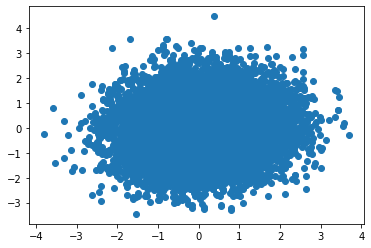

In [318]:
#Defining the forward model, being able to sample from the forward dist at any timestep t
timesteps = 300
# betas = linear_beta_schedule(timesteps)
betas = linear_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = torch.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = torch.sqrt(variance)

import torch.nn.functional as F

#what does this line do ==> adds a 1 to the start of alphas_ and 0 to the end, so corresponding
#index is the previous alpha
alphas_prev_ = F.pad(alphas_[:-1], [1, 0], "constant", 1.0)

#draws from forward model at t = timestep using x_0 = batch
def get_noisy(batch, timestep):
    added_noise_at_t = torch.normal(batch*torch.sqrt(alphas_[timestep]), std=sd[timestep])
    return added_noise_at_t
    

#final timestep should just be gaussian noise
added_noise_at_t = get_noisy(data_transformed, timesteps-1)
plt.scatter(added_noise_at_t[0], added_noise_at_t[1])

posterior_variance = (1 - alphas) #* (1 - alphas_prev_) / (1 - alphas)

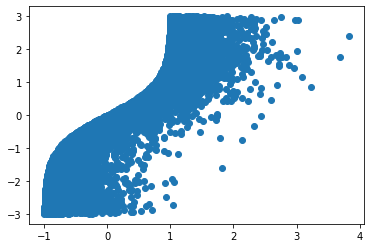

In [319]:
#target
plt.scatter(x, y)

In [320]:
torch.var_mean(data_transformed, dim=1), torch.var_mean(added_noise_at_t, dim=1)

((tensor([0.7597, 3.0297], dtype=torch.float64),
  tensor([0.3071, 0.0200], dtype=torch.float64)),
 (tensor([1.0004, 1.1001], dtype=torch.float64),
  tensor([0.0813, 0.0047], dtype=torch.float64)))

In [246]:
torch.sqrt(torch.Tensor([1., 1.])*alphas_[49])

tensor([0.9576, 0.9576])

(tensor([0.0001, 0.0002, 0.0002, 0.0003, 0.0004, 0.0004, 0.0005, 0.0006, 0.0006,
         0.0007, 0.0008, 0.0008, 0.0009, 0.0010, 0.0010, 0.0011, 0.0012, 0.0012,
         0.0013, 0.0014, 0.0014, 0.0015, 0.0016, 0.0016, 0.0017, 0.0018, 0.0018,
         0.0019, 0.0020, 0.0020, 0.0021, 0.0022, 0.0022, 0.0023, 0.0024, 0.0024,
         0.0025, 0.0026, 0.0026, 0.0027, 0.0028, 0.0028, 0.0029, 0.0030, 0.0030,
         0.0031, 0.0032, 0.0032, 0.0033, 0.0034, 0.0034, 0.0035, 0.0036, 0.0036,
         0.0037, 0.0038, 0.0038, 0.0039, 0.0040, 0.0040, 0.0041, 0.0042, 0.0042,
         0.0043, 0.0044, 0.0044, 0.0045, 0.0046, 0.0046, 0.0047, 0.0048, 0.0048,
         0.0049, 0.0050, 0.0050, 0.0051, 0.0052, 0.0052, 0.0053, 0.0054, 0.0054,
         0.0055, 0.0056, 0.0056, 0.0057, 0.0058, 0.0058, 0.0059, 0.0060, 0.0060,
         0.0061, 0.0062, 0.0062, 0.0063, 0.0064, 0.0064, 0.0065, 0.0066, 0.0066,
         0.0067, 0.0068, 0.0068, 0.0069, 0.0070, 0.0070, 0.0071, 0.0072, 0.0072,
         0.0073, 0.0074, 0.0

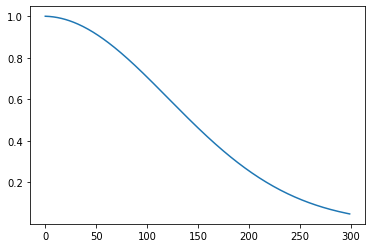

In [247]:
plt.plot(alphas_)

posterior_variance, alphas, alphas_, (alphas_prev_[1] / (1-alphas_prev_[1])) - (alphas_[1] / (1-alphas_[1]))

In [248]:
total_params = sum(p.numel() for p in denoising_model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 7586


In [249]:
#model

In [250]:
learning_rate = 2e-4
batch_size = 100

from torch import nn

class DenoisingModel(nn.Module):
    
    def __init__(self, hidden_units=32):
        super(DenoisingModel, self).__init__()
        # hidden_units = 32
        
        # data and timestep
        self.fc1 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.activation1 = nn.GELU()
        self.fc2 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.activation2 = nn.GELU()
        self.fc3 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc3.weight)
        self.activation3 = nn.GELU()
        
        self.fc4 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc4.weight)
        self.activation4 = nn.GELU()
        self.fc5 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc5.weight)
        self.activation5 = nn.GELU()
        self.fc6 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc6.weight)
        self.activation6 = nn.GELU()
        
        self.fc7 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc7.weight)
        self.activation7 = nn.GELU()
        self.fc8 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc8.weight)
        self.activation8 = nn.GELU()
        self.fc9 = nn.Linear(int(hidden_units), 2, bias=True)
        nn.init.xavier_uniform_(self.fc9.weight)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.fc4(x)
        x = self.activation4(x)
        x = self.fc5(x)
        x = self.activation5(x)
        x = self.fc6(x)
        x = self.activation6(x)
        x = self.fc7(x)
        x = self.activation7(x)
        x = self.fc8(x)
        x = self.activation8(x)
        x = self.fc9(x)
        
        return x
      
denoising_model = DenoisingModel()
denoising_model = denoising_model.to(torch.double)
print(denoising_model)

loss_func = nn.MSELoss()

optimizer = torch.optim.Adam(denoising_model.parameters(), lr=learning_rate)

DenoisingModel(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (activation1): GELU(approximate='none')
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (activation2): GELU(approximate='none')
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (activation3): GELU(approximate='none')
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (activation4): GELU(approximate='none')
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (activation5): GELU(approximate='none')
  (fc6): Linear(in_features=32, out_features=32, bias=True)
  (activation6): GELU(approximate='none')
  (fc7): Linear(in_features=32, out_features=32, bias=True)
  (activation7): GELU(approximate='none')
  (fc8): Linear(in_features=32, out_features=32, bias=True)
  (activation8): GELU(approximate='none')
  (fc9): Linear(in_features=32, out_features=2, bias=True)
)


In [251]:
denoising_model.train()

DenoisingModel(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (activation1): GELU(approximate='none')
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (activation2): GELU(approximate='none')
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (activation3): GELU(approximate='none')
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (activation4): GELU(approximate='none')
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (activation5): GELU(approximate='none')
  (fc6): Linear(in_features=32, out_features=32, bias=True)
  (activation6): GELU(approximate='none')
  (fc7): Linear(in_features=32, out_features=32, bias=True)
  (activation7): GELU(approximate='none')
  (fc8): Linear(in_features=32, out_features=32, bias=True)
  (activation8): GELU(approximate='none')
  (fc9): Linear(in_features=32, out_features=2, bias=True)
)

In [252]:
import os
import os.path as osp
from copy import deepcopy
import pickle
import sys

epochs = 100

def train_model(denoising_model, data_transformed, model_name):
    best_loss = sys.float_info.max
    ff = osp.join(os.getcwd(), 'saved_models', 'best', model_name + '_state.pkl')
    losses = []
    for epoch in range(1, epochs+1):
        for n in range(1, int(len(data_transformed[0])/batch_size) + 1):
            data_in_batch = data_transformed[:, (n-1)*batch_size:(n*batch_size)]
            idx = torch.randint(0, timesteps-1, (batch_size, )).long()
            timestep = idx.add(1)
            data_noisy = get_noisy(data_in_batch, timestep)
            optimizer.zero_grad(set_to_none=True)
            data_noisy_stacked = torch.vstack([data_noisy, timestep])
            pred_data = denoising_model(data_noisy_stacked.t())
            imp_weight = torch.sqrt(1/2 * ((alphas_prev_[timestep] / (1 - alphas_prev_[timestep])) - (alphas_[timestep]/(1 - alphas_[timestep]))))
            # loss on prediction
            loss_ = loss_func(data_in_batch.mul(imp_weight), pred_data.t().mul(imp_weight))
            # norm = tensor.norm(pred_data.sub(data_noisy), dim=0)
            # loss = loss_*norm
            loss_.backward()
            optimizer.step()
            
        ## evaluating noise on a fixed timestep to calculate best model
        with torch.no_grad():
            one_timestep = torch.Tensor([1]).repeat(batch_size).long()
            data_noisy_temp = get_noisy(data_in_batch, one_timestep)
            data_noisy_stacked_temp = torch.vstack([data_noisy_temp, one_timestep])
            pred_data_temp = denoising_model(data_noisy_stacked_temp.t())
            # loss on prediction
            loss_temp = loss_func(data_in_batch.mul(1), pred_data_temp.t().mul(1))
            losses.append(loss_temp.item())
            
        if loss_temp.item() < best_loss:
            best_loss = loss_temp.item()
            print(f"saving epoch: {epoch} loss: {best_loss:>7f}")
                
        if epoch % 20 == 0:
            loss = loss_temp.item()
            print(f"epoch: {epoch} loss: {loss:>7f}")

    return data_noisy, pred_data, data_in_batch, timestep, losses

data_noisy, pred_data, data_in_batch, timestep, losses = train_model(denoising_model, data_transformed, 'denoising_model')

saving epoch: 1 loss: 1.878824
saving epoch: 2 loss: 1.440947
saving epoch: 3 loss: 0.307489
saving epoch: 4 loss: 0.066406
saving epoch: 5 loss: 0.051953
saving epoch: 7 loss: 0.046545
saving epoch: 8 loss: 0.033377
saving epoch: 9 loss: 0.032320
saving epoch: 10 loss: 0.030263
saving epoch: 11 loss: 0.027551
saving epoch: 12 loss: 0.021233
saving epoch: 13 loss: 0.020484
saving epoch: 15 loss: 0.018353
saving epoch: 16 loss: 0.018256
saving epoch: 18 loss: 0.016019
saving epoch: 19 loss: 0.013841
epoch: 20 loss: 0.017166
saving epoch: 21 loss: 0.009162
saving epoch: 23 loss: 0.008124
saving epoch: 24 loss: 0.007371
saving epoch: 25 loss: 0.005209
saving epoch: 27 loss: 0.004834
saving epoch: 29 loss: 0.004054
saving epoch: 31 loss: 0.003281
saving epoch: 36 loss: 0.002673
saving epoch: 38 loss: 0.002021
saving epoch: 39 loss: 0.002012
epoch: 40 loss: 0.002279
saving epoch: 42 loss: 0.001465
saving epoch: 47 loss: 0.001113
saving epoch: 49 loss: 0.000949
saving epoch: 51 loss: 0.00087

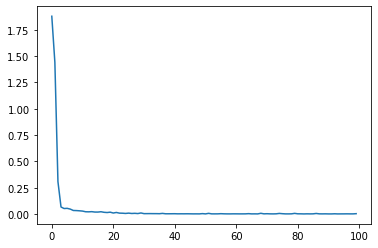

In [253]:
plt.plot(torch.Tensor(losses))

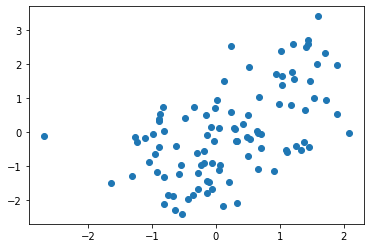

In [254]:
plt.scatter(data_noisy[0], data_noisy[1])

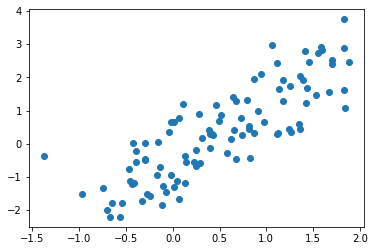

In [255]:
pd = pred_data.detach().numpy().T
plt.scatter(pd[0], pd[1])

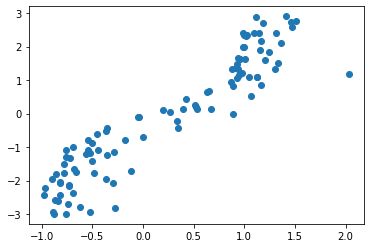

In [256]:
d = data_in_batch.detach().numpy()
plt.scatter(d[0], d[1])

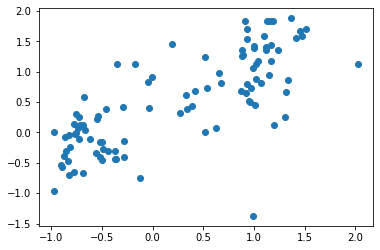

In [257]:
plt.scatter(d[0], pd[0])

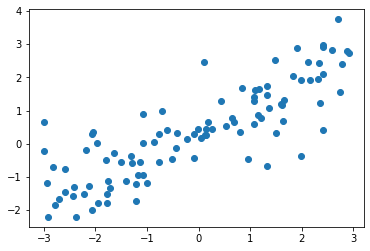

In [258]:
plt.scatter(d[1], pd[1])

In [259]:
def generate_data(denoising_model):
    # final_step_data = get_noisy(data_transformed, timesteps-1)
    # mean_last_step = torch.mean(final_step_data, dim=1)
    # std_last_step = torch.std(final_step_data, dim=1)
    batch_size_generation = 2048
    # (tensor([0.4086, 0.4253]), tensor([-0.6379,  0.0137])))
    data_noisy =  torch.normal(mean=0, std=1, size=(2, batch_size_generation))
    # data_noisy_x =  torch.normal(mean=mean_last_step[0], std=std_last_step[0], size=(1, batch_size_generation))

    # data_noisy = torch.vstack([data_noisy_x, data_noisy_y])


    datas = []
    datas.append(data_noisy.cpu().detach())
    for n in range(1, int(len(data_noisy[0])/batch_size_generation) + 1):
        data_in_batch = data_noisy[:, (n-1)*batch_size_generation:(n*batch_size_generation)]
        for t in range(1, timesteps):
            timestep = timesteps-t
            t_repeated = torch.Tensor([timestep]).repeat(batch_size_generation)
            data_stacked = torch.vstack([data_in_batch, t_repeated])
            data_stacked = data_stacked.to(torch.double)
            pred_data = denoising_model(data_stacked.t())
            mean_data_1 = data_in_batch.t().mul(torch.sqrt(alphas[timestep])*(1-alphas_prev_[timestep])/(variance[timestep]))
            mean_data_2 = pred_data.mul(torch.sqrt(alphas_prev_[timestep])*(1-alphas[timestep])/(variance[timestep]))
            mean_data = mean_data_1.add(mean_data_2)
            posterior_data = posterior_variance[timestep]
            data_in_batch = torch.normal(mean_data, torch.sqrt(posterior_data)).t()
            datas.append(data_in_batch.cpu().detach())
    return datas, data_in_batch

datas, data_in_batch = generate_data(denoising_model)

(-3.5, 3.5)

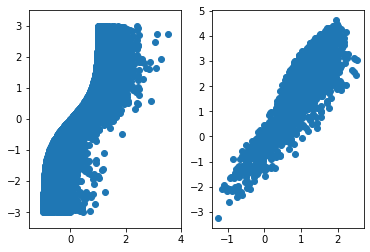

In [260]:
data_in_batch = data_in_batch.cpu().detach()
#data_pred = reverse_transform(data_in_batch.cpu().detach(), min_, max_)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(data_transformed[0], data_transformed[1])
ax2.scatter(data_in_batch[0], data_in_batch[1])
ax1.set_xlim([-1.5, 4])
ax1.set_ylim([-3.5, 3.5])

#ax2.set_xlim([-1.5, 4])
#ax2.set_ylim([-3.5, 3.5])

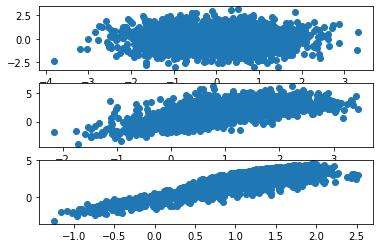

In [261]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[timesteps - 299][0], datas[timesteps - 299][1])
ax6.scatter(datas[timesteps - 45][0], datas[timesteps - 45][1])
ax7.scatter(datas[timesteps - 1][0], datas[timesteps - 1][1])

<ipython-input-262-0e8c0900f562>:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda filename: imageio.imread(filename), filenames))


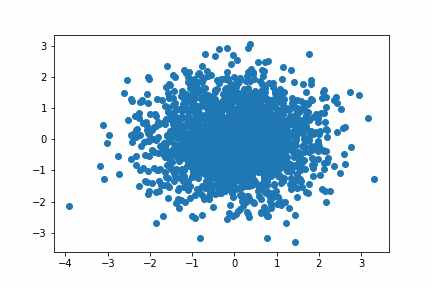

In [262]:
import imageio 
from IPython.display import Image

def print_gif(datas, name):
    filenames = []
    for i in range(0, timesteps-20, 10):
        # plot the line chart
        plt.scatter(datas[i][0], datas[i][1])
        #plt.ylim(-10,10)
        #plt.xlim(-10, 10)

        # create file name and append it to a list
        filename = f'para-{i}.png'
        filenames.append(filename)

        # save frame
        plt.savefig(filename)
        plt.close()

    for j in range(timesteps-20, timesteps-1, 1):
    # plot the line chart
        plt.scatter(datas[j][0], datas[j][1])
        #plt.ylim(-10,10)
        #plt.xlim(-10, 10)

        # create file name and append it to a list
        filename = f'para-{i+j}.png'
        filenames.append(filename)

        # save frame
        plt.savefig(filename)
        plt.close()

    images = list(map(lambda filename: imageio.imread(filename), filenames))

    imageio.mimsave(os.path.join(name), images, ms=300) # modify the frame duration as needed

    # Remove files
    for filename in set(filenames):
        os.remove(filename)
    with open(name,'rb') as f:
        display(Image(data=f.read(), format='png'))


print_gif(datas, 'para.gif')

In [42]:
PATH = "model.pt"

# Save the model
torch.save(denoising_model.state_dict(), PATH)

In [45]:
# Define your model architecture
model = DenoisingModel()
model = denoising_model.to(torch.double)

# Load the saved model parameters into your model
model.load_state_dict(torch.load(PATH))

# Set dropout and batch normalization layers to evaluation mode before running inference
model.eval()

DenoisingModel(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (activation1): GELU(approximate='none')
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (activation2): GELU(approximate='none')
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (activation3): GELU(approximate='none')
  (fc4): Linear(in_features=3, out_features=32, bias=True)
  (activation4): GELU(approximate='none')
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (activation5): GELU(approximate='none')
  (fc6): Linear(in_features=32, out_features=3, bias=True)
  (activation6): GELU(approximate='none')
  (fc7): Linear(in_features=3, out_features=32, bias=True)
  (activation7): GELU(approximate='none')
  (fc8): Linear(in_features=32, out_features=32, bias=True)
  (activation8): GELU(approximate='none')
  (fc9): Linear(in_features=32, out_features=2, bias=True)
)

In [263]:
###############################
###############################
###############################
###############################

In [ ]:
#change so model now predicts the noise in the point, not the original start point

In [228]:
y = -6 * torch.rand(100000) + 3

In [229]:
z = np.random.gamma(1,0.3, size = 100000)

In [230]:
x = np.tanh(y) + z

In [231]:
data = torch.vstack([x, y])

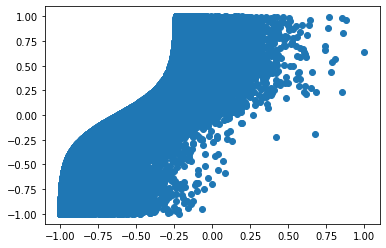

In [232]:
def transform(data):
    min_, max_ = torch.min(data, axis=1), torch.max(data, axis=1)
    data_transformed = 2 * (data.sub(min_.values[:, None])).div((max_.values - min_.values)[:, None]) - 1
    return data_transformed, min_, max_

data_transformed, min_, max_ = transform(data)
plt.scatter(data_transformed[0], data_transformed[1])
#plt.xlim([-1, 1])
#plt.ylim([-1, 1])

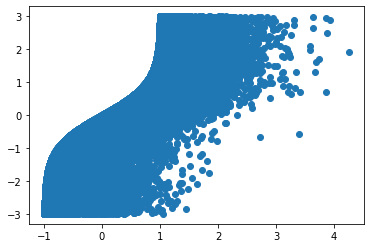

In [233]:
def reverse_transform(data_transformed, min_, max_):
    # data_transformed = 2 * (data.sub(min_.values[:, None])).div((max_.values - min_.values)[:, None]) - 1
    data = (data_transformed + 1).mul((max_.values - min_.values)[:, None]).add(min_.values[:, None]*2)/2
    return data
    
data = reverse_transform(data_transformed, min_, max_)
plt.scatter(data[0], data[1])
#plt.xlim([-5, 50])
#plt.ylim([-20, 20])

In [234]:
# train model
## schedules copied from https://huggingface.co/blog/annotated-diffusion

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

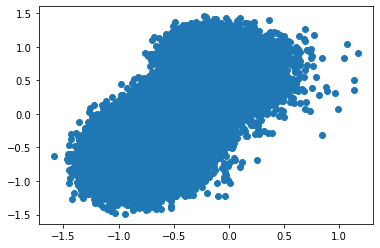

In [235]:
#Defining the forward model, being able to sample from the forward dist at any timestep t
timesteps = 200
betas = linear_beta_schedule(timesteps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
variance = 1 - alphas_cumprod
sd = torch.sqrt(variance)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)


import torch.nn.functional as F

alphas_prev_ = F.pad(alphas_cumprod[:-1], [1, 0], "constant", 1.0)
sigma_squared_q_t = (1 - alphas) * (1 - alphas_cumprod) / (1 - alphas_prev_)
log_sigma_squared_q_t = torch.log(1-alphas) + torch.log(1-alphas_cumprod) - torch.log(1-alphas_prev_)
sigma_squared_q_t_corrected = torch.exp(log_sigma_squared_q_t)
#draws from forward model at t = timestep using x_0 = batch
def get_noisy(batch, timestep, noise = None):
    if noise == None:
        noise = torch.normal(0,1,size = batch.shape)
    
    noisy = batch.mul(sqrt_alphas_cumprod[timestep]) + noise.mul(sd[timestep])
    return noisy
    
def recover_original(batch, timestep, noise):
    true_data = (batch.sub(noise.mul(sd[timestep]))).div(alphas_cumprod[timestep])
    return true_data

#final timestep should just be gaussian noise
test_noise = torch.normal(0,1,size = data_transformed.shape)
added_noise_at_t = get_noisy(data_transformed, 20, test_noise)
plt.scatter(added_noise_at_t[0], added_noise_at_t[1])

posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_cumprod)

log_posterior_variance = torch.log(torch.hstack([posterior_variance[1], posterior_variance[1:]]))
posterior_variance_corrected = torch.exp(log_posterior_variance)

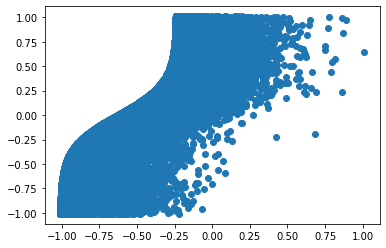

In [236]:
recovered = recover_original(added_noise_at_t, 20, test_noise)
plt.scatter(recovered[0], recovered[1])

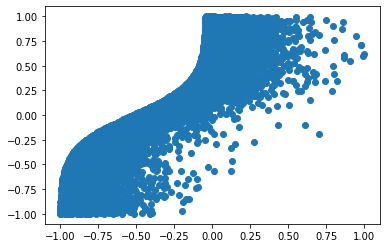

In [219]:
#target
plt.scatter(data_transformed[0], data_transformed[1])

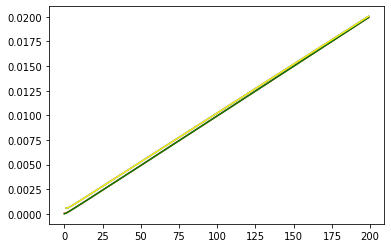

In [220]:
plt.plot(posterior_variance_corrected, c='red')
plt.plot(posterior_variance, c='green')
plt.plot(sigma_squared_q_t_corrected, c='blue')
plt.plot(sigma_squared_q_t, c='yellow')

In [381]:
#model

In [334]:
learning_rate = 1e-3
batch_size = 2048

from torch import nn

class DenoisingModel(nn.Module):
    
    def __init__(self, hidden_units=32):
        super(DenoisingModel, self).__init__()
        # hidden_units = 32
        
        # data and timestep
        self.mlp = nn.Sequential(
            nn.Linear(3, int(hidden_units), bias=True),
            nn.ReLU(),
            nn.Linear(int(hidden_units), int(hidden_units/2), bias=True),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), int(hidden_units/4), bias=True),
            nn.ReLU(),
            nn.Linear(int(hidden_units/4), int(hidden_units/8), bias=True),
            nn.ReLU(),
            nn.Linear(int(hidden_units/8), int(hidden_units/16), bias=True),
            nn.ReLU(),
            nn.Linear(int(hidden_units/16), int(hidden_units/8), bias=True),
            nn.ReLU(),
            nn.Linear(int(hidden_units/8), int(hidden_units/4), bias=True),
            nn.ReLU(),
            nn.Linear(int(hidden_units/4), int(hidden_units/2), bias=True),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), int(hidden_units), bias=True),
            nn.ReLU(),
            nn.Linear(int(hidden_units), 2, bias=True)
        )
        
        
        
    def forward(self, x):
        x = self.mlp(x)
        return x
      
denoising_model = DenoisingModel()
denoising_model = denoising_model.to(torch.double)
print(denoising_model)

loss_func = nn.MSELoss()

optimizer = torch.optim.Adam(denoising_model.parameters(), lr=learning_rate)

DenoisingModel(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=2, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2, out_features=4, bias=True)
    (11): ReLU()
    (12): Linear(in_features=4, out_features=8, bias=True)
    (13): ReLU()
    (14): Linear(in_features=8, out_features=16, bias=True)
    (15): ReLU()
    (16): Linear(in_features=16, out_features=32, bias=True)
    (17): ReLU()
    (18): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [238]:
denoising_model.train()

DenoisingModel(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=8, out_features=4, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=4, out_features=2, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=2, out_features=4, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=4, out_features=8, bias=True)
    (13): GELU(approximate='none')
    (14): Linear(in_features=8, out_features=16, bias=True)
    (15): GELU(approximate='none')
    (16): Linear(in_features=16, out_features=32, bias=True)
    (17): GELU(approximate='none')
    (18): Linear(in_features=32, out_features=2, bias=True)
  )
)

loss: 0.632921  [   10/ 2048]


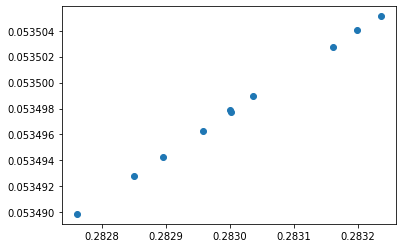

In [239]:
##### testing neural network above

test_noise_step = 5
noise = torch.normal(0,1,size = data_transformed[:, 0:10].shape)
data_noisy= get_noisy(data_transformed[:, 0:10], test_noise_step, noise)
# torch.hstack([data_noisy, torch.Tensor(5)])
t_ = torch.Tensor([test_noise_step])
t_ = t_.repeat(10)
data_noisy = torch.vstack([data_noisy, t_])

with torch.no_grad():
    for epoch in range(1, 2):
        data_pred = denoising_model(data_noisy.t())
        loss_ = loss_func(noise[:, 0:10].t(), data_pred)
        loss, current = loss_.item(), 1 * 10
        print(f"loss: {loss:>7f}  [{current:>5d}/{batch_size:>5d}]")
    
# print(data_pred, data_transformed[:, 1:10].T)

plt.scatter(data_pred.t()[0], data_pred.t()[1])

In [339]:
import os
import os.path as osp
from copy import deepcopy
import pickle
import sys

epochs = 300

def train_model(denoising_model, data_transformed, model_name):
    best_loss = sys.float_info.max
    ff = osp.join(os.getcwd(), 'saved_models', 'best', model_name + '_state.pkl')
    losses = []
    for epoch in range(1, epochs+1):
        for n in range(1, int(len(data_transformed[0])/batch_size) + 1):
            data_in_batch = data_transformed[:, (n-1)*batch_size:(n*batch_size)]
            idx = torch.randint(0, timesteps-1, (batch_size, )).long()
            timestep = idx.add(1)
            noise = torch.normal(0,1,size = data_in_batch.shape)
            data_noisy = get_noisy(data_in_batch, timestep, noise)
            
            optimizer.zero_grad(set_to_none=True)
            data_noisy_stacked = torch.vstack([data_noisy, timestep])
            pred_data = denoising_model(data_noisy_stacked.t()).to(torch.float32)
            imp_weight = torch.sqrt(1/2 * ((alphas_prev_[timestep] / (1 - alphas_prev_[timestep])) - (alphas_cumprod[timestep]/(1 - alphas_cumprod[timestep]))))
            # loss on prediction
            imp_weight = torch.sqrt(1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (variance[timestep] * alphas[timestep])))
            imp_weight = 1
            loss_ = loss_func(noise.mul(imp_weight), pred_data.t().mul(imp_weight))
            # norm = tensor.norm(pred_data.sub(data_noisy), dim=0)
            # loss = loss_*norm
            loss_.backward()
            optimizer.step()
            
        ## evaluating noise on a fixed timestep to calculate best model
        with torch.no_grad():
            one_timestep = torch.Tensor([1]).repeat(batch_size).long()
            noise_temp = torch.normal(0,1,size = data_in_batch.shape)
            data_noisy_temp = get_noisy(data_in_batch, one_timestep, noise_temp)
            data_noisy_stacked_temp = torch.vstack([data_noisy_temp, one_timestep])
            pred_data_temp = denoising_model(data_noisy_stacked_temp.t())
            # loss on prediction
            loss_temp = loss_func(noise_temp.mul(1), pred_data_temp.t().mul(1))
            losses.append(loss_temp.item())
            
        if loss_temp.item() < best_loss:
            best_loss = loss_temp.item()
            print(f"saving epoch: {epoch} loss: {best_loss:>7f}")
                
        if epoch % 20 == 0:
            loss = loss_temp.item()
            print(f"epoch: {epoch} loss: {loss:>7f}")

    return data_noisy, pred_data, data_in_batch, timestep, losses

#data_noisy, pred_data, data_in_batch, timestep, losses = train_model(denoising_model, data_transformed, 'denoising_model')

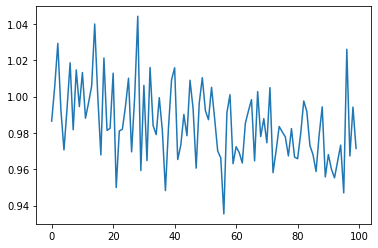

In [241]:
plt.plot(torch.Tensor(losses))

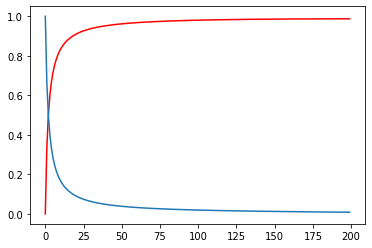

In [243]:
mean_coeff_1 = torch.sqrt(alphas)*(1 - alphas_prev_) / variance
mean_coeff_2 = torch.sqrt(alphas_prev_) * betas / variance

plt.plot(mean_coeff_1, color='red')
plt.plot(mean_coeff_2)

In [259]:
def generate_data(denoising_model):
    # final_step_data = get_noisy(data_transformed, timesteps-1)
    # mean_last_step = torch.mean(final_step_data, dim=1)
    # std_last_step = torch.std(final_step_data, dim=1)
    batch_size_generation = 2048
    # (tensor([0.4086, 0.4253]), tensor([-0.6379,  0.0137])))
    data_noisy =  torch.normal(mean=0, std=1, size=(2, batch_size_generation))
    # data_noisy_x =  torch.normal(mean=mean_last_step[0], std=std_last_step[0], size=(1, batch_size_generation))

    # data_noisy = torch.vstack([data_noisy_x, data_noisy_y])


    datas = []
    datas.append(data_noisy.cpu().detach())
    for n in range(1, int(len(data_noisy[0])/batch_size_generation) + 1):
        data_in_batch = data_noisy[:, (n-1)*batch_size_generation:(n*batch_size_generation)]
        for t in range(1, timesteps):
            timestep = timesteps-t
            t_repeated = torch.Tensor([timestep]).repeat(batch_size_generation)
            data_stacked = torch.vstack([data_in_batch, t_repeated])
            #data_stacked = data_stacked.to(torch.double)
            pred_data = denoising_model(data_stacked.t())
            multiplier = torch.exp(torch.log((betas[timestep])) - torch.log(sd[timestep]))
            mean_data = (data_in_batch.t().sub(pred_data.mul(multiplier))).div(torch.sqrt(alphas[timestep]))
            posterior_data = posterior_variance_corrected[timestep]
            data_in_batch = torch.normal(mean_data, torch.sqrt(posterior_data)).t()
            datas.append(data_in_batch.cpu().detach())
    return datas, data_in_batch

#datas, data_in_batch = generate_data(denoising_model)

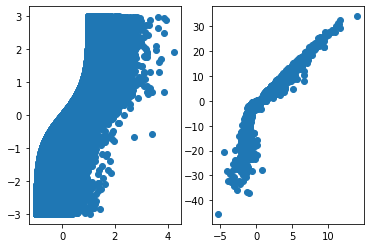

In [248]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_, max_)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(data[0], data[1])
ax2.scatter(data_pred[0], data_pred[1])
#ax1.set_xlim([-1.5, 4])
#ax1.set_ylim([-3.5, 3.5])

#ax2.set_xlim([-1.5, 4])
#ax2.set_ylim([-3.5, 3.5])

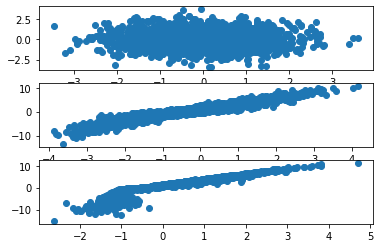

In [249]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[timesteps - 199][0], datas[timesteps - 199][1])
ax6.scatter(datas[timesteps - 45][0], datas[timesteps - 45][1])
ax7.scatter(datas[timesteps - 1][0], datas[timesteps - 1][1])

<ipython-input-250-6ebe8f8aac9c>:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda filename: imageio.imread(filename), filenames))


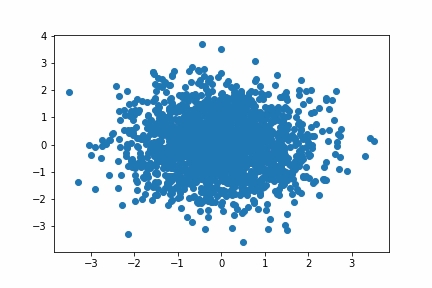

In [250]:
import imageio 
from IPython.display import Image

def print_gif(datas, name):
    filenames = []
    for i in range(0, timesteps-20, 5):
        # plot the line chart
        plt.scatter(datas[i][0], datas[i][1])
        #plt.ylim(-10,10)
        #plt.xlim(-10, 10)

        # create file name and append it to a list
        filename = f'para-{i}.png'
        filenames.append(filename)

        # save frame
        plt.savefig(filename)
        plt.close()

    for j in range(timesteps-20, timesteps-1, 1):
    # plot the line chart
        plt.scatter(datas[j][0], datas[j][1])
        #plt.ylim(-10,10)
        #plt.xlim(-10, 10)

        # create file name and append it to a list
        filename = f'para-{i+j}.png'
        filenames.append(filename)

        # save frame
        plt.savefig(filename)
        plt.close()

    images = list(map(lambda filename: imageio.imread(filename), filenames))

    imageio.mimsave(os.path.join(name), images, ms=300) # modify the frame duration as needed

    # Remove files
    for filename in set(filenames):
        os.remove(filename)
    with open(name,'rb') as f:
        display(Image(data=f.read(), format='png'))


print_gif(datas, 'para.gif')

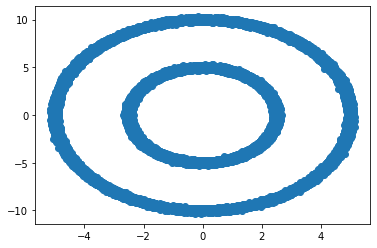

In [340]:
circles, _ = datasets.make_circles(1024*128, noise=0.01, factor=0.5, shuffle=True)
circles = circles* [5., 10.] 
circles = circles.T
plt.scatter(circles[0], circles[1])

DenoisingModel(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): ReLU()
    (10): Linear(in_features=8, out_features=16, bias=True)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=64, bias=True)
    (15): ReLU()
    (16): Linear(in_features=64, out_features=128, bias=True)
    (17): ReLU()
    (18): Linear(in_features=128, out_features=2, bias=True)
  )
)
saving epoch: 1 loss: 1.024414
saving epoch: 2 loss: 1.007256
saving epoch: 4 loss: 0.995269
saving epoch: 9 loss: 0.986130
saving epoch: 10 loss: 0.984639
saving epoch: 12 loss: 0.974973
saving epoch: 13

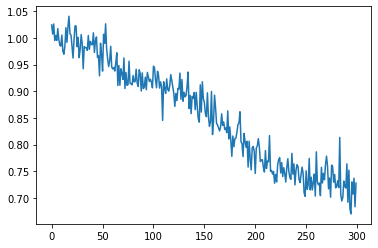

In [341]:
make_circles_model = DenoisingModel(128)
print(make_circles_model)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(make_circles_model.parameters(), lr=learning_rate)

circles = torch.Tensor(circles)
circles_normalized, min_circles, max_circles = transform(circles)
data_noisy, pred_data, data_in_batch, _, losses = train_model(make_circles_model, circles_normalized, 'pred_error_make_circles_model.seq')
plt.plot(torch.Tensor(losses))

In [342]:
datas, data_in_batch = generate_data(make_circles_model)

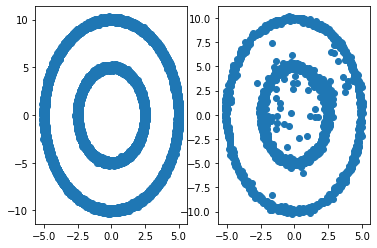

In [343]:
#without imp
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_circles, max_circles)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(circles[0], circles[1])
ax2.scatter(data_pred[0], data_pred[1])

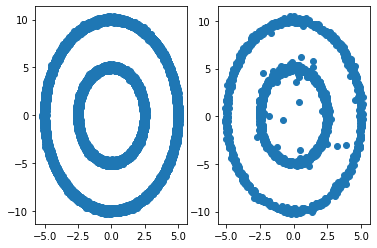

In [275]:
#with imp
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_circles, max_circles)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(circles[0], circles[1])
ax2.scatter(data_pred[0], data_pred[1])

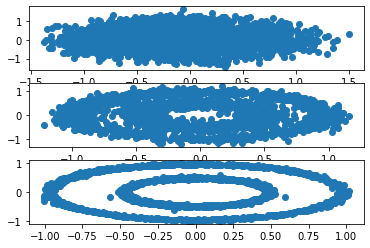

In [328]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[timesteps - 25][0], datas[timesteps - 25][1])
ax6.scatter(datas[timesteps - 12][0], datas[timesteps - 12][1])
ax7.scatter(datas[timesteps - 1][0], datas[timesteps - 1][1])

<ipython-input-250-6ebe8f8aac9c>:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = list(map(lambda filename: imageio.imread(filename), filenames))


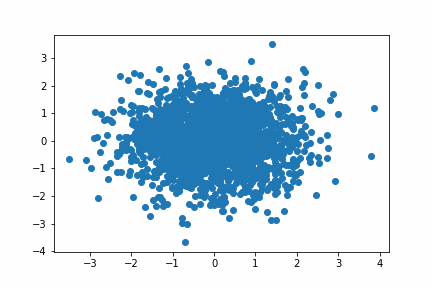

In [329]:
print_gif(datas, 'circles.gif')

In [301]:
test= [i[0] for i in data_pred.T if abs(i[1] - 0) < 0.3]

In [303]:
test = torch.stack(test)

(array([0.17601755, 0.        , 0.28162802, 0.01760175, 0.        ,
        0.        , 0.        , 0.29922977, 0.        , 0.21122097]),
 array([-5.0350304 , -4.020521  , -3.0060115 , -1.991502  , -0.9769926 ,
         0.03751683,  1.0520263 ,  2.0665357 ,  3.0810452 ,  4.0955544 ,
         5.110064  ], dtype=float32),
 <a list of 10 Patch objects>)

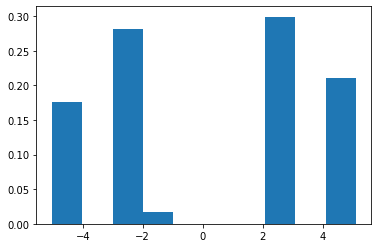

In [304]:
plt.hist(test, density=True)

In [306]:
test.reshape(-1,1)

tensor([[ 2.4627],
        [ 4.9728],
        [-2.4520],
        [-2.4265],
        [ 2.4289],
        [-2.4932],
        [ 2.4951],
        [-2.4446],
        [ 2.5733],
        [ 2.5379],
        [-2.3580],
        [-4.9106],
        [ 5.0476],
        [ 2.3816],
        [-2.4781],
        [ 5.1101],
        [ 4.9757],
        [ 4.8536],
        [ 2.5839],
        [-2.5706],
        [ 4.8915],
        [-2.4099],
        [ 2.5729],
        [-5.0350],
        [ 5.0307],
        [-2.4518],
        [-4.9242],
        [-2.5708],
        [-4.9170],
        [-4.9386],
        [ 2.3126],
        [ 2.7902],
        [-2.2152],
        [-2.5607],
        [-4.8702],
        [ 2.5226],
        [-5.0288],
        [-4.9100],
        [-1.8257],
        [-2.5685],
        [ 2.6360],
        [-2.4596],
        [-2.5551],
        [ 5.0319],
        [ 5.0281],
        [-4.8875],
        [-4.9907],
        [ 5.1050],
        [ 2.4961],
        [ 2.6370],
        [ 4.9322],
        [-2.3375],
        [ 2.

In [317]:
from sklearn.neighbors import KernelDensity
X_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(test.reshape(-1,1))
log_dens = kde.score_samples(X_plot)

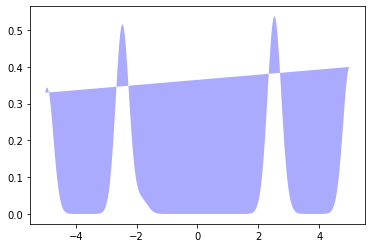

In [318]:
plt.fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")

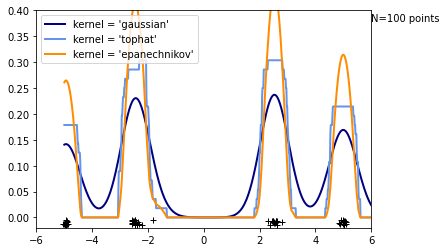

In [322]:
N = 100
np.random.seed(1)
X = test.reshape(-1,1)

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

#true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
#ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-6, 6)
ax.set_ylim(-0.02, 0.4)
plt.show()

(array([[0.        , 0.        , 0.04642729, 0.08876317, 0.10754382,
         0.1081568 , 0.0874449 , 0.04566292, 0.        , 0.        ],
        [0.04634975, 0.02329673, 0.06494946, 0.05880864, 0.04898997,
         0.04878688, 0.05896004, 0.06452112, 0.02343705, 0.04589925]]),
 array([-10.316252  ,  -8.250132  ,  -6.184011  ,  -4.1178904 ,
         -2.05177   ,   0.01435041,   2.0804708 ,   4.146591  ,
          6.212712  ,   8.278832  ,  10.344953  ], dtype=float32),
 <a list of 2 Lists of Patches objects>)

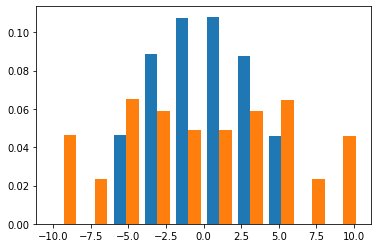

In [284]:
plt.hist(circles, density=True)